In [1]:
import numpy as np
from qiskit import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
import random
import math
from qiskit.tools.monitor import job_monitor
from qiskit import pulse        
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib 
%matplotlib inline

In [2]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy141')
backend = provider.get_backend('ibmq_johannesburg')
backend_config = backend.configuration()

In [5]:
import numpy as np

backend_defaults = backend.defaults()
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns") 

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 1

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

Sampling time: 0.2222222222222222 ns


In [6]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=qubit)

In [7]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [11]:
# Rabi experiment parameters
num_amplitudes = 8
num_rabi_points = 50

# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.

pulse_info = []
rabi_jobs = []
all_drive_amps = []

drive_sigmas = np.geomspace(0.002, 0.04, num_amplitudes)
# Repeat the Rabi experiment for {num_amplitude} amplitudes. Each experiment is its own job
for i in range(num_amplitudes):
    # Drive amplitude values to iterate over: amplitudes evenly spaced from 0 to 0.75
    drive_amp_min = 0
    drive_amp_max = 0.75-(i*0.065)
    drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)
    all_drive_amps.append(drive_amps)
    
    # Drive pulse parameters (us = microseconds)
    drive_sigma_us = drive_sigmas[i]        # This determines the actual width of the gaussian
    drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                               # a natural finite length

    drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
    drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt

    pulse_info.append([drive_sigma, drive_samples])
    
    rabi_schedules = []
    
    # Build the Rabi experiments:
        #    A drive pulse at the qubit frequency, followed by a measurement,
        #    where we vary the drive amplitude each time.
    for drive_amp in drive_amps:
        rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                        sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
        this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
        this_schedule += Play(rabi_pulse, drive_chan)

        this_schedule += measure << this_schedule.duration
        rabi_schedules.append(this_schedule)
        
        
    # Assemble the schedules into a Qobj
    num_shots_per_point = 1024
        
    rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: backend_defaults.qubit_freq_est[qubit]}]
                                                * num_rabi_points)

    job = backend.run(rabi_experiment_program)
    rabi_jobs.append(job.job_id())

In [12]:
rabi_jobs

['5ef39df3eedb51001324aa7a',
 '5ef39df574e2c3001237d4e0',
 '5ef39df8dc3044001186beef',
 '5ef39dfa6c16190012683975',
 '5ef39dfcfbc24b001275af96',
 '5ef39dff0935ad0012f6356b',
 '5ef39e02041ca700148e96cb',
 '5ef39e0674e2c3001237d4e2']

In [13]:
rabi_values = []

for i in range(len(rabi_jobs)):
    job = backend.retrieve_job(rabi_jobs[i])
    results = job.result(timeout=120)
    
    amp_values = []
    for j in range(num_rabi_points):
        amp_values.append(results.get_memory(j)[qubit] * scale_factor)
    rabi_values.append(amp_values)
        
rabi_values = [np.real(baseline_remove(x)) for x in rabi_values]

In [60]:
rabi_fit_params = []
y_fits = []
amp_guesses = np.linspace(0.55, 0.02, num_amplitudes)

for i in range(len(rabi_values)):
    fit_params, y_fit = fit_function(all_drive_amps[i],
                                     rabi_values[i], 
                                     lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                     [1, 0, amp_guesses[i], 0])
    rabi_fit_params.append(fit_params)
    y_fits.append(y_fit)

Amplitude: 0.060841434934049914 dt


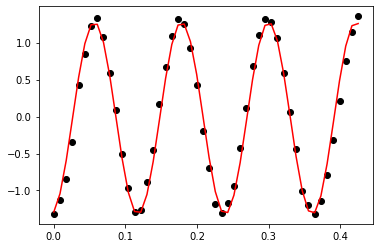

In [61]:
a = 5
plt.scatter(all_drive_amps[a], rabi_values[a], color='black')
plt.plot(all_drive_amps[a], y_fits[a], color='red')
print(f'Amplitude: {abs(rabi_fit_params[a][2] / 2)} dt')

In [54]:
for i in range(num_amplitudes):
    pi_amp = abs(rabi_fit_params[i][2] / 2)
#     pulse_info[i].append(pi_amp)
    print(f"Pi Amplitude = {abs(rabi_fit_params[i][2] / 2)}")
    print(f"Duration = {pulse_info[i][1]}")
    print(f"Sigma = {pulse_info[i][0]}")
#     print(f"Period = {pulse_info[i][3]}")
    print()

Pi Amplitude = 0.3530500137690539
Duration = 80
Sigma = 16

Pi Amplitude = 0.32235243432845956
Duration = 112
Sigma = 16

Pi Amplitude = 0.3187914520833258
Duration = 176
Sigma = 16

Pi Amplitude = 0.15421520791740806
Duration = 256
Sigma = 32

Pi Amplitude = 0.1028823095632427
Duration = 400
Sigma = 48

Pi Amplitude = 0.09761239624950298
Duration = 608
Sigma = 80

Pi Amplitude = 0.06370666786771047
Duration = 944
Sigma = 112

Pi Amplitude = 0.026888747770390797
Duration = 1440
Sigma = 176



In [62]:
pulse_info = [[16, 80, 0.3530500137690539],
 [16, 112, 0.32235243432845956],
 [16, 176, 0.3187914520833258],
 [32, 256, 0.15421520791740806],
 [48, 400, 0.1028823095632427],
 [80, 608, 0.060841434934049914],
 [112, 944, 0.04288369610097112],
 [176, 1440, 0.026888747770390797]]

In [63]:
num_rabi_stretches = 50

all_durations = []
rabi_stretch_jobs = []

for i in range(len(pulse_info)):
    rabi_stretch_schedules = []
    durations = []

    drive_samples = pulse_info[i][1]
    
    for j in range(num_rabi_stretches):
        duration = get_closest_multiple_of_16(drive_samples+(j*16))
        rabi_pulse = pulse_lib.GaussianSquare(duration=duration, 
                                        amp=pulse_info[i][2], 
                                        sigma=pulse_info[i][0],
                                        width=drive_samples+(j*16)-(2*pulse_info[i][0]),
                                        name=f"Rabi duration = {duration}")

        this_schedule = pulse.Schedule(name=f"Rabi duration = {duration}")
        this_schedule += Play(rabi_pulse, drive_chan)

        this_schedule += measure << this_schedule.duration
        rabi_stretch_schedules.append(this_schedule)
        durations.append(duration)
    
    all_durations.append(durations)
    
    # Assemble the schedules into a Qobj
    num_shots_per_point = 1024

    rabi_stretch_program = assemble(rabi_stretch_schedules,
                                       backend=backend,
                                       meas_level=1,
                                       meas_return='avg',
                                       shots=num_shots_per_point,
                                       schedule_los=[{drive_chan: backend_defaults.qubit_freq_est[qubit]}]
                                                    * num_rabi_stretches)
    stretch_job = backend.run(rabi_stretch_program)
    rabi_stretch_jobs.append(stretch_job.job_id())

In [64]:
rabi_stretch_jobs

['5ef3bbd30935ad0012f63680',
 '5ef3bbd66c16190012683a96',
 '5ef3bbd9eedb51001324ab80',
 '5ef3bbdb74e2c3001237d5fb',
 '5ef3bbde6c16190012683a99',
 '5ef3bbe174e2c3001237d5fc',
 '5ef3bbe4eedb51001324ab82',
 '5ef3bbe874e2c3001237d5fd']

In [65]:
rabi_stretch_values = []

for i in range(len(rabi_stretch_jobs)):
    job = backend.retrieve_job(rabi_stretch_jobs[i])
    results = job.result(timeout=120)

    period_values = []
    for j in range(num_rabi_stretches):
        period_values.append(results.get_memory(j)[qubit] * scale_factor)
    rabi_stretch_values.append(period_values)
        
rabi_stretch_values = [np.real(baseline_remove(x)) for x in rabi_stretch_values]

In [135]:
rabi_stretch_params = []
y_stretch_fits = []
period_guesses = np.geomspace(55, 700, num_amplitudes, endpoint=False)

fun = lambda x,A,B,T,phi: (A*np.cos(2*np.pi*x/T+phi)+B)

for i in range(len(rabi_stretch_values)):
    fit_params, cov = curve_fit(fun,
                           all_durations[i],
                           rabi_stretch_values[i],
                           [3, 0, 65, 0],
                           maxfev=3000)

    rabi_stretch_params.append(fit_params)
    y_fit = [fun(x, fit_params[0], fit_params[1], fit_params[2], fit_params[3]) for x in all_durations[i]]
    y_stretch_fits.append(y_fit)

Period for amp: 0.3530500137690539, 70.18453963827605 dt


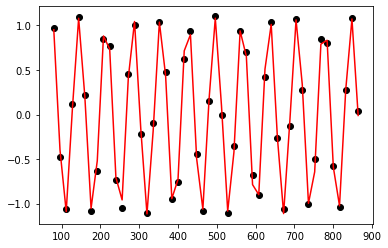

In [136]:
p = 0
plt.scatter(all_durations[p], rabi_stretch_values[p], color='black')
plt.plot(all_durations[p], y_stretch_fits[p], color='red')
print(f'Period for amp: {pulse_info[p][2]}, {rabi_stretch_params[p][2]} dt')

In [100]:
for i in range(num_amplitudes):
    period = rabi_stretch_params[i][2]
#     pulse_info[i].append(period)
    print(f"Pi Amplitude = {pulse_info[i][2]}")
    print(f"Period = {period}")
    print()

Pi Amplitude = 0.3530500137690539
Period = 53.79569306938365

Pi Amplitude = 0.32235243432845956
Period = 76.10424563894914

Pi Amplitude = 0.3187914520833258
Period = 100.7338494367827

Pi Amplitude = 0.15421520791740806
Period = 151.66160913455937

Pi Amplitude = 0.1028823095632427
Period = 225.2530813937307

Pi Amplitude = 0.060841434934049914
Period = 379.60417279044793

Pi Amplitude = 0.04288369610097112
Period = 539.941450467514

Pi Amplitude = 0.026888747770390797
Period = 862.92141357997



In [140]:
edited_pulse_info = np.array([
       [1.60000000e+01, 8.00000000e+01, 3.53050014e-01, 7.01845396e+01],
       [1.60000000e+01, 1.12000000e+02, 3.22352434e-01, 7.61042456e+01],
       [1.60000000e+01, 1.76000000e+02, 3.18791452e-01, 7.68814178e+01],
       [3.20000000e+01, 2.56000000e+02, 1.54215208e-01, 1.51661609e+02],
       [4.80000000e+01, 4.00000000e+02, 1.02882310e-01, 2.25253081e+02],
       [8.00000000e+01, 6.08000000e+02, 6.08414349e-02, 3.79604173e+02],
       [1.12000000e+02, 9.44000000e+02, 4.28836961e-02, 5.39941450e+02],
       [1.76000000e+02, 1.44000000e+03, 2.68887478e-02, 8.62921414e+02]])

edited_pulse_info

array([[1.60000000e+01, 8.00000000e+01, 3.53050014e-01, 7.01845396e+01],
       [1.60000000e+01, 1.12000000e+02, 3.22352434e-01, 7.61042456e+01],
       [1.60000000e+01, 1.76000000e+02, 3.18791452e-01, 7.68814178e+01],
       [3.20000000e+01, 2.56000000e+02, 1.54215208e-01, 1.51661609e+02],
       [4.80000000e+01, 4.00000000e+02, 1.02882310e-01, 2.25253081e+02],
       [8.00000000e+01, 6.08000000e+02, 6.08414349e-02, 3.79604173e+02],
       [1.12000000e+02, 9.44000000e+02, 4.28836961e-02, 5.39941450e+02],
       [1.76000000e+02, 1.44000000e+03, 2.68887478e-02, 8.62921414e+02]])

Conversion constant: 23.66156363955276. Exponent: -0.9940037912357684


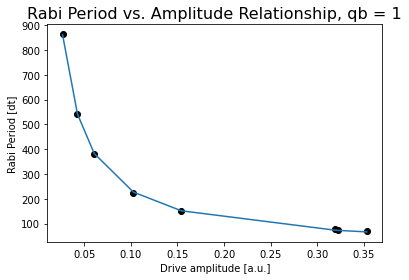

In [141]:
per_amp_power_fit = lambda x,A,n: A*(x**n)
per_params, _ = curve_fit(per_amp_power_fit, edited_pulse_info[:, 2] , edited_pulse_info[:, 3], p0=[50, -1])
amp_fit = per_amp_power_fit(edited_pulse_info[:, 2], *per_params)

plt.plot(edited_pulse_info[:, 2], amp_fit, label='Amplitude decay fit')
plt.scatter(edited_pulse_info[:, 2], edited_pulse_info[:, 3], color='black')
plt.xlabel("Drive amplitude [a.u.]")
plt.ylabel("Rabi Period [dt]")
plt.title("Rabi Period vs. Amplitude Relationship, qb = " + str(qubit), fontsize=16)
print(f'Conversion constant: {per_params[0]}. Exponent: {per_params[1]}')

In [142]:
predict_const = per_params[0]
predict_power = per_params[1]
drive_amp = lambda period: np.power(period/predict_const,1/predict_power)

In [147]:
drive_amp(40)

0.5896685524793539

Conversion constant: 5.35893609525708. Exponent: -0.9654741107610489


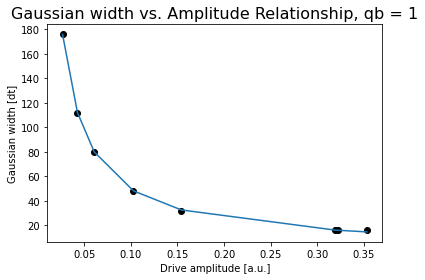

In [144]:
sig_amp_power_fit = lambda x,A,n: A*(x**n)
sig_params, _ = curve_fit(sig_amp_power_fit, edited_pulse_info[:, 2] , edited_pulse_info[:, 0], p0=[3, -1])
sig_fit = sig_amp_power_fit(edited_pulse_info[:, 2], *sig_params)

plt.plot(edited_pulse_info[:, 2], sig_fit, label='Amplitude decay fit')
plt.scatter(edited_pulse_info[:, 2], edited_pulse_info[:, 0], color='black')
plt.xlabel("Drive amplitude [a.u.]")
plt.ylabel("Gaussian width [dt]")
plt.title("Gaussian width vs. Amplitude Relationship, qb = " + str(qubit), fontsize=16)
print(f'Conversion constant: {sig_params[0]}. Exponent: {sig_params[1]}')